
[INFO] Memproses exports_usd and imports_usd tahun 2000.png...
  -> ✅ Area plot berhasil dideteksi.
  [DEBUG] Teks hasil OCR dari sumbu Y: ''
  -> ⚠️ Peringatan OCR: Kurang dari 2 label Y terdeteksi.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> Mengekstrak variabel: 'exports_usd'...
  -> Mengekstrak variabel: 'imports_usd'...
  -> ✅ Sukses: Data untuk 2 variabel diekstrak dan digabung.

[INFO] Memproses exports_usd and imports_usd tahun 2001.png...
  -> ✅ Area plot berhasil dideteksi.
  [DEBUG] Teks hasil OCR dari sumbu Y: ''
  -> ⚠️ Peringatan OCR: Kurang dari 2 label Y terdeteksi.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> Mengekstrak variabel: 'exports_usd'...
  -> Mengekstrak variabel: 'imports_usd'...
  -> ✅ Sukses: Data untuk 2 variabel diekstrak dan digabung.

[INFO] Memproses exports_usd and imports_usd tahun 2002.png...
  -> ✅ Area plot berhasil dideteksi.
  [DEBUG] Teks hasil OCR dari sumbu Y: ''
  -> ⚠️ Peringatan OCR: Kur

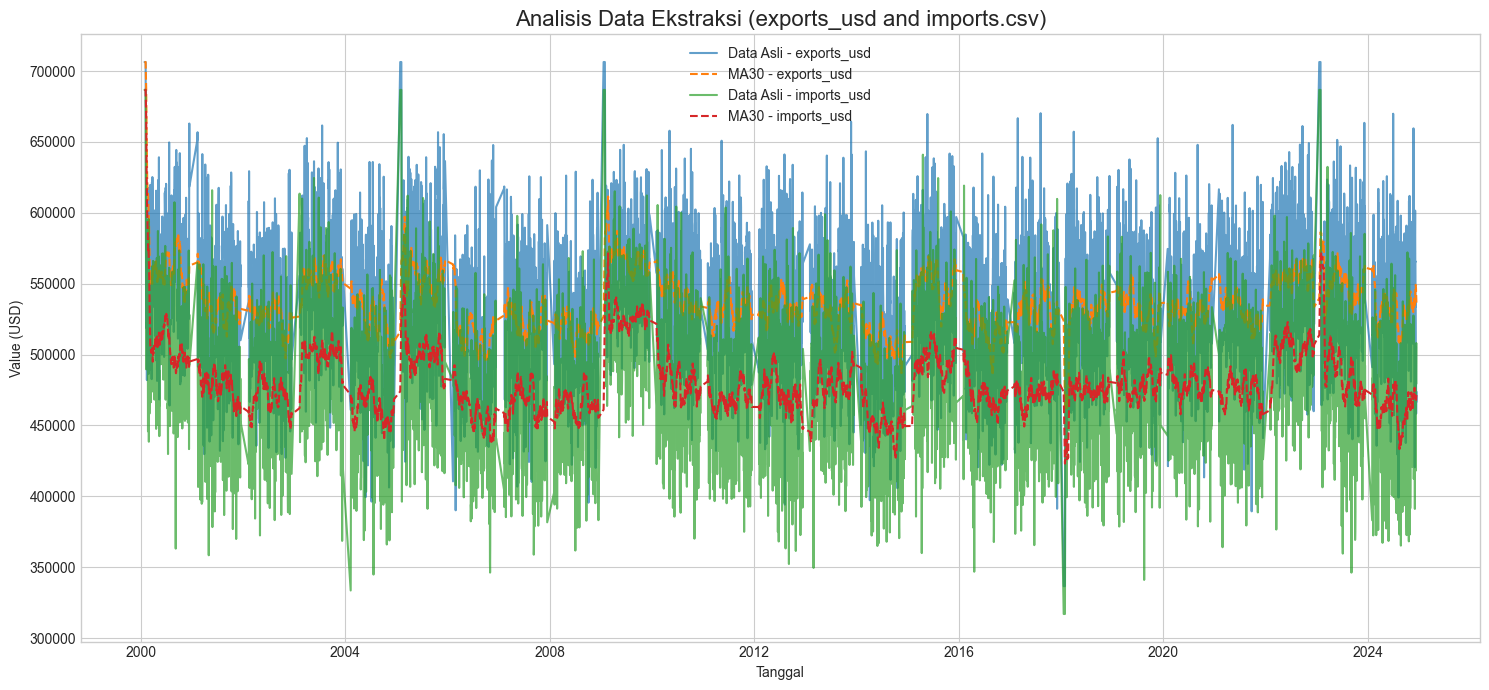

In [11]:
# ==============================================================================
# Script Ekstraksi Data Grafik v4.6 (Final - Perbaikan Typo & Peningkatan OCR)
# Deskripsi:
#   - Memperbaiki AttributeError: COLOR_BGR_HSV -> COLOR_BGR2HSV.
#   - Meningkatkan akurasi OCR dengan memperbesar gambar sumbu-Y sebelum dibaca.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta
from functools import reduce

# ==============================================================================
# 1. KONFIGURASI SCRIPT
# ==============================================================================
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

CONFIG = {
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C03\exports_usd and imports_usd",
    "output_csv_file": "exports_usd and imports.csv",
    "fallback_y_min": 250000.0,
    "fallback_y_max": 750000.0,
    "clamp_y_min": 300000.0,
    "clamp_y_max": 750000.0,
    "variables": [
        {
            "name": "exports_usd",
            "lower_color": np.array([100, 150, 50]),
            "upper_color": np.array([130, 255, 255])
        },
        {
            "name": "imports_usd",
            "lower_color": np.array([10, 150, 100]),
            "upper_color": np.array([25, 255, 255])
        }
    ],
    "visualize_output": True
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def save_debug_image(folder_path, filename, step_name, image):
    debug_folder = os.path.join(folder_path, "debug")
    if not os.path.exists(debug_folder): os.makedirs(debug_folder)
    base_name = os.path.splitext(filename)[0]
    debug_filename = f"{base_name}_{step_name}.png"
    cv2.imwrite(os.path.join(debug_folder, debug_filename), image)
    print(f"  [DEBUG] Gambar '{debug_filename}' disimpan di folder debug.")

# ==============================================================================
# 3. FUNGSI DETEKSI & KALIBRASI
# ==============================================================================
def find_plot_area(image: np.ndarray, filename: str, folder_path: str) -> Optional[Tuple[np.ndarray, Dict[str, int]]]:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
    kernel = np.ones((20, 20), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    if w > image.shape[1] * 0.5 and h > image.shape[0] * 0.5 and w > h:
        padding = 5
        x_pad, y_pad, w_pad, h_pad = x + padding, y + padding, w - (2*padding), h - (2*padding)
        return image[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad], {'x': x_pad, 'y': y_pad, 'w': w_pad, 'h': h_pad}
    return None

def calibrate_yaxis(image: np.ndarray, plot_coords: Dict[str, int]) -> Optional[Dict[str, float]]:
    try:
        yaxis_crop = image[plot_coords['y']:plot_coords['y']+plot_coords['h'], 0:plot_coords['x']]
        
        # [PERBAIKAN] Tingkatkan kualitas gambar untuk OCR yang lebih baik
        # 1. Perbesar gambar (upscaling) agar teks lebih jelas
        h, w = yaxis_crop.shape[:2]
        upscaled_yaxis = cv2.resize(yaxis_crop, (w * 2, h * 2), interpolation=cv2.INTER_CUBIC)
        
        # 2. Ubah ke grayscale dan tingkatkan kontras
        gray_yaxis = cv2.cvtColor(upscaled_yaxis, cv2.COLOR_BGR2GRAY)
        gray_yaxis = cv2.convertScaleAbs(gray_yaxis, alpha=1.5, beta=0)
        
        # Jalankan OCR pada gambar yang sudah ditingkatkan kualitasnya
        ocr_text = pytesseract.image_to_string(gray_yaxis, config='--psm 6 -c tessedit_char_whitelist=0123456789')
        print(f"  [DEBUG] Teks hasil OCR dari sumbu Y: '{ocr_text.replace('\n', ' ')}'")
        
        ocr_numbers = sorted([float(n) for n in re.findall(r'\b\d{5,}\b', ocr_text)], reverse=True)
        if len(ocr_numbers) < 2: 
            print("  -> ⚠️ Peringatan OCR: Kurang dari 2 label Y terdeteksi.")
            return None

        plot_gray = cv2.cvtColor(image[plot_coords['y']:plot_coords['y']+plot_coords['h'], plot_coords['x']:plot_coords['x']+plot_coords['w']], cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(plot_gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=plot_coords['w']*0.8, maxLineGap=10)
        if lines is None: return None

        grid_y_coords = sorted(list(set([line[0][1] for line in lines])))
        if len(grid_y_coords) >= 2 and len(ocr_numbers) >= 2:
            top_line_y, bottom_line_y = grid_y_coords[0], grid_y_coords[-1]
            if len(ocr_numbers) > len(grid_y_coords): ocr_numbers = ocr_numbers[:len(grid_y_coords)]
            top_val, bottom_val = ocr_numbers[0], ocr_numbers[-1]
            pixel_span, value_span = bottom_line_y - top_line_y, top_val - bottom_val
            if pixel_span == 0 or value_span == 0: return None
            
            pixels_per_value = pixel_span / value_span
            calibrated_y_max = top_val + (top_line_y / pixels_per_value)
            calibrated_y_min = calibrated_y_max - (plot_coords['h'] / pixels_per_value)
            
            print(f"  -> ✅ Kalibrasi Sumbu Y berhasil: Min={calibrated_y_min:.2f}, Max={calibrated_y_max:.2f}")
            return {'min': calibrated_y_min, 'max': calibrated_y_max}
    except Exception as e:
        print(f"  -> ⚠️ Peringatan Kalibrasi: {e}")
    return None

# ==============================================================================
# 4. FUNGSI EKSTRAKSI & PEMROSESAN
# ==============================================================================
def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            extracted_data.append({"Date": date.strftime("%Y-%m-%d"), "Year": params['year'], "DayOfYear": day_of_year + 1, params['var_name']: round(value, 2)})
    if not extracted_data: return pd.DataFrame()
    df = pd.DataFrame(extracted_data)
    return df.groupby('Date').agg({params['var_name']: 'mean', 'Year': 'first', 'DayOfYear': 'first'}).reset_index()

def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    if df.empty: return df
    proc_df = df.copy(); proc_df['Date'] = pd.to_datetime(proc_df['Date']); proc_df = proc_df.sort_values(by='Date').set_index('Date').drop(columns=['Year', 'DayOfYear'], errors='ignore'); proc_df.interpolate(method='time', inplace=True); proc_df.dropna(inplace=True);
    vars_to_analyze = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns: proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30, min_periods=1).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"; plt.style.use('seaborn-v0_8-whitegrid'); fig, ax = plt.subplots(figsize=(15, 7));
    vars_to_plot = [v['name'] for v in config.get('variables', [])]
    for var_name in vars_to_plot:
        if var_name in df.columns: ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7); ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16); ax.set_xlabel("Tanggal"); ax.set_ylabel("Value (USD)"); ax.legend(); plt.tight_layout(); plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']): print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'."); return
    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
    if not all_files: print(f"❌ KESALAHAN: Tidak ada file gambar ditemukan di folder."); return
    all_results = []
    
    for filename in all_files:
        print(f"\n{'='*25}\n[INFO] Memproses {filename}...\n{'='*25}")
        full_path = os.path.join(config['folder_path'], filename)
        img = cv2.imread(full_path)
        if img is None: continue

        plot_info = find_plot_area(img, filename, config['folder_path'])
        if not plot_info: print(f"  -> ⏭️ Gagal mendeteksi plot area. Melewati file {filename}."); continue
        plot_area, plot_coords = plot_info
        print("  -> ✅ Area plot berhasil dideteksi.")
        
        calibration = calibrate_yaxis(img, plot_coords)
        if calibration: y_min, y_max = calibration['min'], calibration['max']
        else: print("  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback."); y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

        year_match = re.search(r'(\d{4})', filename)
        if not year_match: print(f"  -> ⚠️ Peringatan: Tidak ada tahun di nama file '{filename}'. File dilewati."); continue
        year_from_file = int(year_match.group(1))

        # [PERBAIKAN] Mengganti COLOR_BGR_HSV menjadi COLOR_BGR2HSV
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        
        year_dataframes = []
        for var_info in config.get('variables', []):
            print(f"  -> Mengekstrak variabel: '{var_info['name']}'...")
            mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
            if not np.any(mask): print(f"  -> ⚠️ Peringatan: Tidak ada piksel warna yang cocok untuk '{var_info['name']}'."); continue
            params = {'year': year_from_file, 'y_min': y_min, 'y_max': y_max, 'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'], 'var_name': var_info['name']}
            df_year_var = extract_series_from_mask(mask, params)
            if not df_year_var.empty: year_dataframes.append(df_year_var)
        
        if year_dataframes:
            merged_df_year = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'Year', 'DayOfYear'], how='outer'), year_dataframes)
            all_results.append(merged_df_year)
            print(f"  -> ✅ Sukses: Data untuk {len(year_dataframes)} variabel diekstrak dan digabung.")

    if not all_results: print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak."); return
    final_df = post_process_data(pd.concat(all_results, ignore_index=True), config)
    if final_df.empty: print("\n⚠️ PROSES SELESAI: Data kosong setelah pemrosesan."); return

    output_path = os.path.join(config['folder_path'], config['output_csv_file'])
    final_df.reset_index().to_csv(output_path, index=False, date_format='%Y-%m-%d')
    print(f"\n✅ SUKSES! {len(final_df)} baris data disimpan ke {output_path}")

    if config.get('visualize_output', True): visualize_results(final_df, config)

if __name__ == '__main__':
    main(CONFIG)